In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
def one_hot_encoding(series):
    '''
    Customized Onehot encoding for handling multiple value answers
    
    Input:
    series: pandas series containing the values of survery answers
    
    Output:
    oh_df: dataframe contains the one hot encoded values of the input series
    
    '''
    one_hot = []
    cat_list = series.str.split(';').explode().str.strip().dropna().unique()
    for val in series.values:
        one_hot.append([1 if cat in str(val) else 0 for cat in cat_list])
        
    oh_df = pd.DataFrame(one_hot,columns=cat_list)
    return oh_df

In [3]:
df_free = pd.read_csv('survey_data_17_to_19.csv',low_memory=False)

# Computation of outliers using the IQR method
Q3 = df_free['Salary'].describe()['75%']
Q1 = df_free['Salary'].describe()['25%']
IQR = Q3-Q1
upper_bound = Q3 + 1.5*IQR
with_salary_no_outlier = (df_free['Salary']>0) & (df_free['Salary']<=upper_bound)

df_free = df_free[with_salary_no_outlier].reset_index(drop=True)
df_free.head()

,Employment,Country,Education,Major,DeveloperType,JobSatisfaction,Salary,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,WebFrameWorkedWith,Year
0,"Independent contractor, freelancer, or self-em...",U.S.,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Back-end developer;Desktop or enterprise appli...,NaN,78000.0,C#;SQL;VB.NET,SQL Server,Windows Desktop or Server,NaN,2018
1,"Independent contractor, freelancer, or self-em...",France,I never completed any formal education,NaN,Front-end developer;Full-stack developer,NaN,3500.0,CoffeeScript;Go;JavaScript;Ruby;HTML;CSS;Bash/...,Redis;PostgreSQL;Memcached;Google Cloud Storage,Google Cloud Platform/App Engine;Heroku;Mac OS...,React.js,2018
2,"Independent contractor, freelancer, or self-em...",U.K.,Some college/university study without earning ...,"Another engineering discipline (ex. civil, ele...",Back-end developer,NaN,11500.0,JavaScript;SQL;HTML;CSS,Oracle,NaN,NaN,2018
3,"Independent contractor, freelancer, or self-em...",Netherlands,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Full-stack developer,NaN,150000.0,Groovy;Java;JavaScript;SQL;TypeScript;HTML;CSS,MongoDB;MySQL;Oracle;Elasticsearch,NaN,Angular;Spring,2018
4,"Independent contractor, freelancer, or self-em...",Azerbaijan,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A business discipline (ex. accounting, finance...",Back-end developer;Front-end developer;Full-st...,NaN,12.0,Java;JavaScript;PHP;SQL;HTML;CSS;Bash/Shell,Cassandra;MongoDB;Redis;MySQL;PostgreSQL;Elast...,AWS;iOS;Linux;Mac OS,Node.js;React,2018


Combines all the one hot encoded variables into one_df 

In [5]:
one_df = pd.DataFrame()
for col in ['DeveloperType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','WebFrameWorkedWith']:
    dev_one_hot = one_hot_encoding(df_free[col]).add_prefix(col+': ')
    one_df = pd.concat([one_df,dev_one_hot],axis=1)
one_df['Salary']=df_free['Salary']
one_df.head()

,DeveloperType: Back-end developer,DeveloperType: Desktop or enterprise applications developer,DeveloperType: Front-end developer,DeveloperType: Full-stack developer,DeveloperType: QA or test developer,DeveloperType: DevOps specialist,DeveloperType: Student,"DeveloperType: C-suite executive (CEO, CTO, etc.)",DeveloperType: Database administrator,DeveloperType: Engineering manager,...,WebFrameWorkedWith: jQuery,WebFrameWorkedWith: Other(s):,WebFrameWorkedWith: ASP.NET,WebFrameWorkedWith: Vue.js,WebFrameWorkedWith: Flask,WebFrameWorkedWith: Ruby on Rails,WebFrameWorkedWith: Laravel,WebFrameWorkedWith: Express,WebFrameWorkedWith: Drupal,Salary
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78000.0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3500.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11500.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,150000.0
4,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0


Train and Test split

In [6]:
y_col = 'Salary'
Xs = one_df.drop(columns=y_col)
y = one_df[y_col]

X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.3,random_state=42)

Modeling

In [7]:
model = LinearRegression()
model.fit(X_train,y_train)
preds = model.predict(X_test)
r2_score(y_test,preds),mean_squared_error(y_test,preds)

(0.051563891137014095, 2949932567.8995824)

In [8]:
feat_coef = pd.DataFrame(X_train.columns,columns=['Feature'])
feat_coef = feat_coef.set_index('Feature')
feat_coef['Coefficient'] = model.coef_

Text(0.5, 1.0, 'DeveloperType')

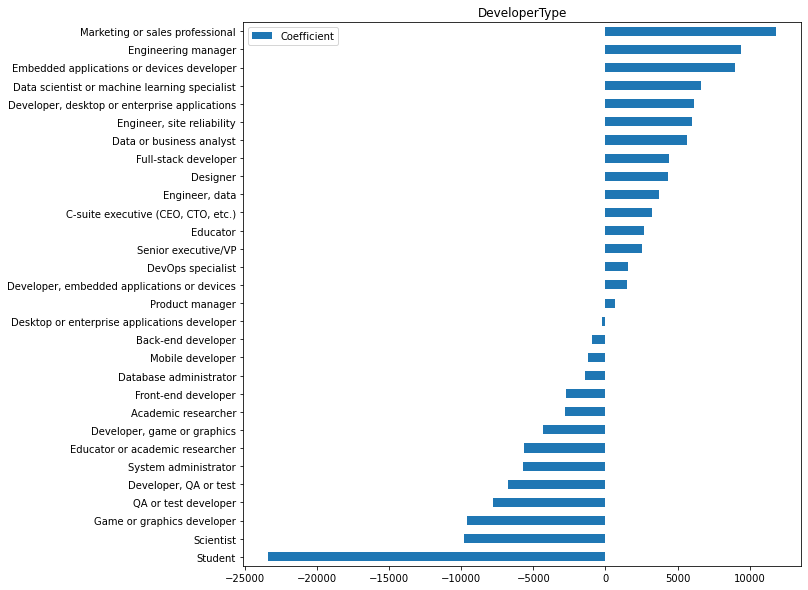

In [9]:
contains_col = feat_coef.index.str.contains('DeveloperType')
sub_feat = feat_coef[contains_col]
sub_feat.index = sub_feat.index.str.replace('DeveloperType'+': ','')
sub_feat.sort_values('Coefficient').plot(kind='barh',figsize=(10,10))
plt.ylabel('')
plt.title('DeveloperType')

In [10]:
contains_col = feat_coef.index.str.contains('DatabaseWorkedWith')
sub_feat = feat_coef[contains_col]
sub_feat.index = sub_feat.index.str.replace('DatabaseWorkedWith'+': ','')
sub_feat.index

Index(['SQL Server', 'Redis', 'PostgreSQL', 'Memcached',
       'Google Cloud Storage', 'Oracle', 'MongoDB', 'MySQL', 'Elasticsearch',
       'Cassandra', 'SQLite', 'Neo4j', 'Microsoft Azure', 'MariaDB',
       'Amazon DynamoDB', 'Amazon RDS/Aurora', 'Google BigQuery', 'IBM Db2',
       'Amazon Redshift', 'Apache HBase', 'Apache Hive',
       'Microsoft SQL Server', 'Firebase', 'Couchbase', 'DynamoDB',
       'Other(s):'],
      dtype='object', name='Feature')

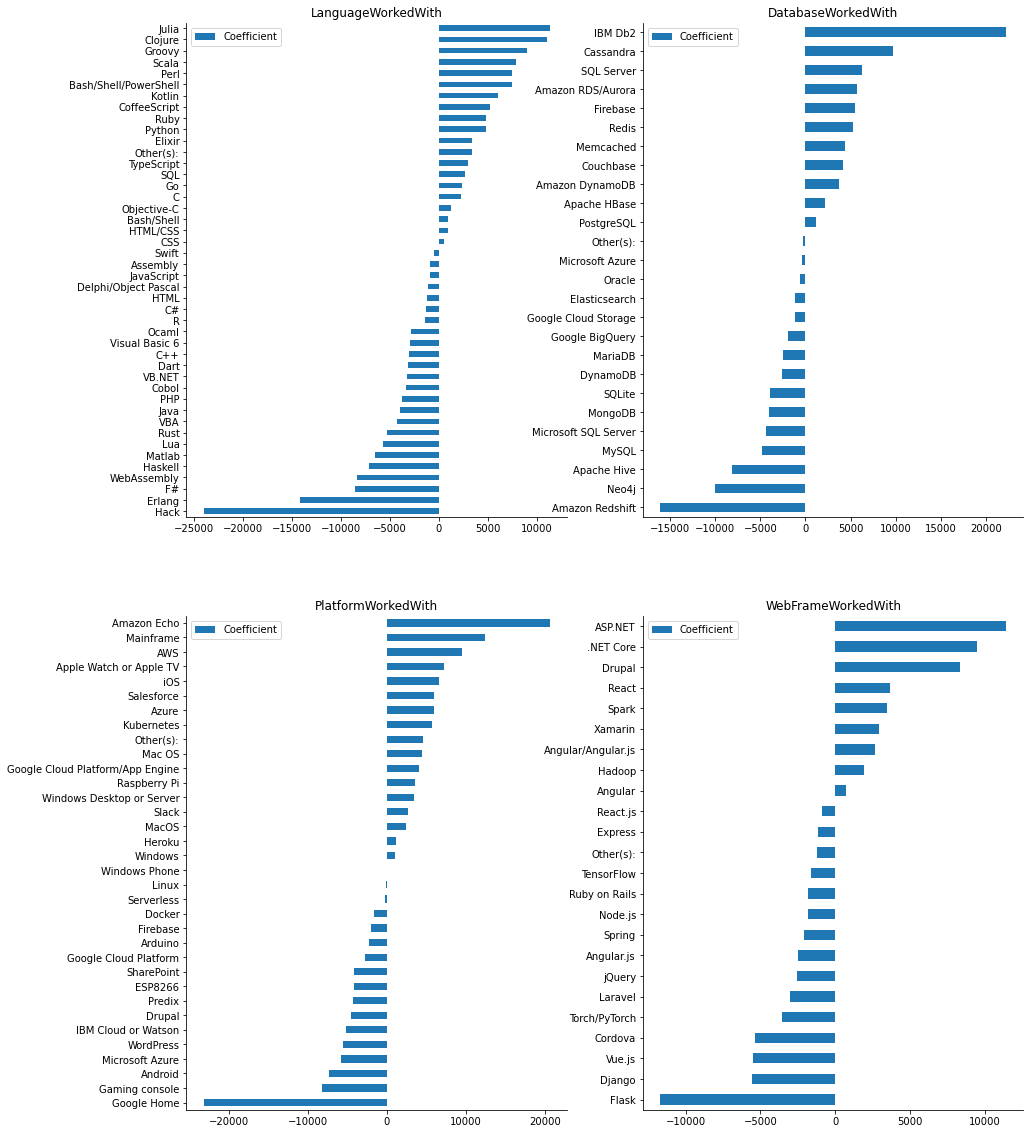

<Figure size 216x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

In [11]:
fig, ax = plt.subplots(2,2,figsize=(15,20))

a = 0
b = 0

for col in ['LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','WebFrameWorkedWith']:
    plt.figure(figsize=(3,10))
    contains_col = feat_coef.index.str.contains(col)
    sub_feat = feat_coef[contains_col]
    sub_feat.index = sub_feat.index.str.replace(col+': ','')
    sub_feat.sort_values('Coefficient').plot(kind='barh',ax=ax[a,b])
    ax[a,b].spines['right'].set_visible(False)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].set_ylabel('')
    ax[a,b].set_title(str(col));
    b+=1
    if(b==2):
        b=0
        a+=1
plt.show();